In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper
%aimport training_models_helper

tmh = training_models_helper.TrainingModelsHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper(random_seed=42)

import recipe_helper
%aimport recipe_helper
rh = recipe_helper.Recipe_Helper()

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Becoming a successful Data Scientist: Error Analysis

As of now, you should know
- how to construct models (the "recipe")
- how to use them for prediction
- some simple metrics on how they perform

In this module, the topics to be covered provide answers:
- model diagnostics 

In other words: the importance of Error Analysis in diagnosing and improving models.

# Classification: Beyond accuracy

Let's re-run the MNIST problem and examine measures of error more detailed than accuracy


In [5]:
mnh = mnist_helper.MNIST_Helper(random_seed=42)
mnh.setup()
_= mnh.fit()

Retrieving MNIST_784 from cache


Examine the score (n.b., ran with L2 penalty)

In [6]:
clf = mnh.clf

 # Cross validation
scores = cross_val_score(clf, mnh.X_train, mnh.y_train, cv=10)
print("Avg cross val score={s:3.2f}\n".format( s=scores.mean()) )

# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100

print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )

Avg cross val score=0.88

Sparsity with l2 penalty: 16.07.


We achieved an out of sample accuracy of about 87%

That sounds good, but is it really ?

If each of the 10 labels occurs with equal frequency among the training examples
- We could mis-predict *every* occurrence of a single digit (i.e., 10% of the training examples)
- And still achieve an Accuracy of 90% if we perfectly predict all other digits

Would that be satisfactory ?

This motivates the need to measure *Conditional Performance* or *Conditional Loss*
- Performance/Loss conditioned on meaningful subsets of training examples

We will examine some conditional metrics for the Classification task.

# Binary classification: Conditional accuracy

An ideal model would have perfect Accuracy.

In the absence of perfection
- we want to measure accuracy *conditional* on subsets of examples.



For a Binary Classification task, we can partition the examples into a two dimensions
- Row labels: the *predicted* class
- Column labels: the *true* class

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

The correct predictions
- True Positives (TP) are   examples predicted as Positive that were in fact Positive
- True Positives (TN) are   examples predicted as Negative that were in fact Negative

The incorrect predictions
- False Positives (FP) are  examples predicted as Positive that were in fact Negative
- False Positives (FN) are  examples predicted as Negative that were in fact Positive


Unconditional Accuracy can thus be written as

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

We can also define some conditional Accuracy measures

## Imbalanced data: the case for conditional accuracy

Conditional Accuracy becomes particularly important
- when the number of 
 Positive and Negative examples in a dataset are quite different
    - Titanic example: many fewer examples with `Survived` than `Not Survived`

This is called *imbalanced* data.

When this occurs, unconditional measures are highly influenced by success on the dominant category
- Titanic example: The Negative examples are almost twice as numerous as the Positive
$$\text{TP} + \text{FN} << \text{TN} + \text{FP}$$

Conditional metrics are one way of placing focus on success in the non-dominant category.

##  Recall (Sensitivity, True Positive Rate: TPR)

Regardless of whether the Positive class is dominant, we may be interested in how well our
model identifies Positive examples.

*Recall* is a metric Conditioned on Positive examples.

$$
\textrm{Recall} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FN} }  }
$$
- The fraction of Positive examples (denominator) that were correctly classified
- Also goes by the names: True Positive Rate (TPR), Sensitivity

**FN** (mis-classified Positive examples) detract from Recall

Why is Recall important ?

Consider a diagnostic test for Covid
- we want to correctly identify Covid positive patients
- even though they are a small fraction of the population
    - hence have a smaller contribution to Unconditional Accuracy than the Negative class

But be careful ! It is easy to achieve 100% Recall.

Degenerate case:
- Always predicting Positive, ignoring all features of the example
    - lots of FP
- Unconditional Accuracy will suffer.
- And FP (Negative patients incorrectly classified as infected) may bear a cost

## Specificity

Similarly: we may be interested in knowing how well our model identifies (or mis-identifies) Negative examples.

For example
- we *don't want to mis-label* as Positive, a patient who is truly Covid Negative.

*Specificity* is a metric conditioned on Negative examples

$$
\textrm{Specificity} = { { \textrm{TN} } \over { \textrm{TN} +  \textrm{FP} }  }
$$

- The fraction of Negative examples that were correctly classified
- Also goes by the name: True Negative Rate (TNR)

**FP** (mis-classified Negative examples) detract from Specificity

A good model (e.g., Covid test) has
- high Recall
    - correctly identifies a large fraction of Positive patients
- high Specificity
    - does not have too many FP (mis-diagnosed Negative patients)
        - who may bear a cost of being mis-diagnosed


## False Positive Rate (FPR)

The fraction of Negative examples misclassified as Positive.

$$
\begin{array}{lll}
\textrm{FPR} & = & { { \textrm{FP} } \over { \textrm{FP} + \textrm{TN} } } \\
             & = & 1 - \textrm{Specificity}
\end{array}
$$

## Precision

Recall seeks to correctly label Positive examples
- degenerate case: label all examples as Positive; achieve 100% Recall

But we would also like to have confidence that our Positive predictions are accurate.

*Precision* is a metric
to tell you the fraction of your Positive predictions that were correct.

$$
\textrm{Precision} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FP} }  }
$$

**FP** (mis-classified Negative examples) detract from Precision.

Just like with Recall, it is easy to achieve 100% Precision.

Degenerate case:
- Predict Positive for only a *single example* that is actually Positive 
    - Lots of FN
    - Recall will suffer


## Precison/Recall Tradeoff

We showed (via degenerate cases) that it was easy to have
**either**
- Perfect Recall
- **OR** Perfect Precision

But it may not be possible to have both.


We will 
- Show how to trade off one measure for the other
- Discuss when to favor one type of error over another

Some Classification models (e.g., Logistic Regression)
- Use hyper-parameters (e.g., threshold)
- To convert a numerical "score" to a Categorical predicted value

By varying the threshold, we can change predictions to favor a particular Conditional Performance metric.

We will show how this happens and demonstrate ways to evaluate the trade-off between metrics.

Recall our methodology for Classification via Logistic Regression:
- Compute a numerical "score" for our example based on its features
$$\hat{s}^\ip = \Theta \cdot \x^\ip$$

- Construct a probability distribution (over the target classes) from the scores
$$\hat{\mathbf{p}}^\ip = \sigma(\hat{s}^\ip)  $$

- Predict by comparing the probability to a threshold


$$
\hat{\y}^\ip = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{\mathbf{p}}^\ip < 0.5   & \text{Negative} \\
    1 & \textrm{if } \hat{\mathbf{p}}^\ip \ge 0.5  & \text{Positive} \\
    \end{array}
    }
\right.
$$

We can visualize the step of converting probabilities to predicted class
by  plotting lines (hyper-planes) of constant score/probability

For a given constant value of score or probability:
- Examples above the line are classified as Positive
- Examples below the line are classified as Negative

We can choose **any score/probability** as our decision boundary for prediction.

Let's see what happens as we vary the boundary.

<table>
    <tr>
        <center><strong>Separation bounday as function of probability threshold</strong></center>
    </tr>
<img src="images/class_overview_prob_lines.jpg" width=1000>
</table>


- By choosing the boundary $$\Theta^T \x = -1 \,\,\, (\text{resp., prob} = 0.27)$$
- Rather than the boundary $$\Theta^T \x =  0 \,\,\, (\text{resp., prob} = 0.50)$$

we potentially **increase** the number of examples classified as Positive
- Increasing the number of TP $\leadsto$ Increasing Recall
- But also potentially increasing the number of FP $\leadsto$ Decreasing Precision

Thus, by varying threshold, we can choose the **trade-off between Recall and Precision**.


For models that rely on a Threshold
- the threshold is a **hyper-parameter**
- that **you can choose**
- in order to achieve some externally-specified objective
    - e.g., high Recall

**Precision vs Recall: which one to favor ?**

What factors might lead us to favor one metric over the other ?

Consider a diagnostic test whose goal is to classify highly infectious patients as Positive
- High Recall: catch most infected patients
- Low Precision: frighten patients that are misclassified as Positive

You might favor Recall
- When a False Negative has very bad consequences (e.g., lead to an increase in infections in population)

You might favor Precision
- When a False Positive has very bad consequences (e.g., cause a non-infected patient to isolate)

Moving the boundary to increase Positives will naturally decrease Negative predictions.

So we also affect metrics conditioned on Negative (FN, TN), with similar trade-offs.


### Precision/Recall trade-off: plot

To be concrete: let's examine the trade-off between Recall and Precision
in the context of a binary classifier
- Using MNIST examples: classify an example as being a **single** chosen digit versus the 9 other digits

- Create a binary classifier for a single MNIST digit

In [7]:
# Fetch the MNIST data into object

mnh_d = mnist_helper.MNIST_Helper(random_seed=42)
mnh_d.setup()

# Turn the 10 class training set into a binary training set
# - Same examples, different targets
# - targets are now "is 'digit'" or "is not 'digit'" for a single digit
digit = '5'
y_train_d, y_test_d = mnh_d.make_binary(digit)

# Fit a binary model: Is digit/Is not digit
mnh_d.fit(y_train=y_train_d)
scores = cross_val_score(mnh_d.clf, mnh_d.X_train, y_train_d, cv=3, scoring="accuracy")

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(mnh_d.clf, mnh_d.X_train, y_train_d, cv=5, method="decision_function")


Retrieving MNIST_784 from cache


LogisticRegression(C=0.01, solver='saga', tol=0.1)

Let's plot the trade-off

In [8]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_d, y_train_pred)

# Convert thresholds (log odds) to probability
probs = np.exp(thresholds)/(1+np.exp(thresholds))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=None):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    
    if probs is None:
        horiz = thresholds
        label = "Threshold"
    else:
        horiz = probs
        label = "Probability threshold"
    _ = ax.plot(horiz, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = ax.plot(horiz, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = ax.set_xlabel(label, fontsize=16)
    _ = ax.legend(loc="upper left", fontsize=16)
    _ = ax.set_ylim([0, 1])
    
    _ = ax.set_xlim([ horiz.min(), horiz.max()])
    
    return fig, ax

fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=probs)
plt.close(fig)

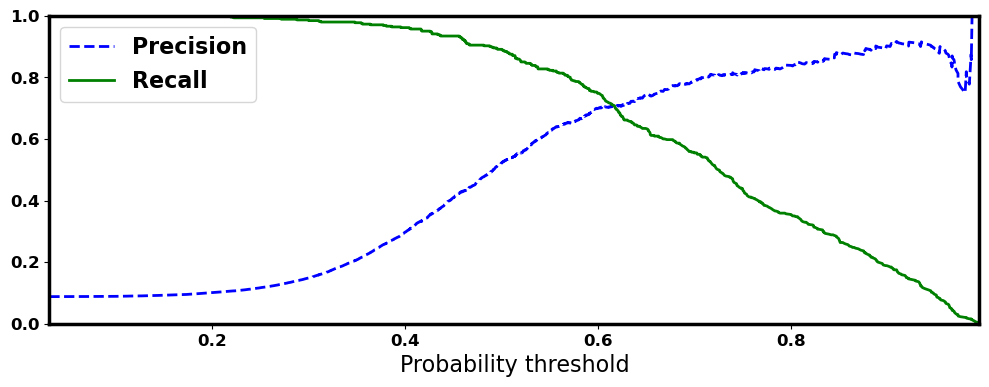

In [9]:
fig

You can see how varying the threshold  affects Recall and Precision
- One at the expense of the other

### ROC/AUC: Evaluating the Precision/Recall tradeoff

There is another common tool used to evaluate the trade-off between competing metrics.

The **ROC** is a plot of True Positive Rate (TPR) versus the False Positive Rate (FPR) 
as we vary the threshold.
- each point in the plot corresponds to a particular threshold
- the TPR and FPR is measured for that threshold


Our goal is to choose a threshold (corresponding to a point on the curve)
- With the highest True Positive Rate (TPR)
    - i.e., Recall
    -  fraction of correctly classified Positives
- With the smallest *acceptable* False Positive Rate (FPR)
    - fraction of negatives that are misclassified as Positive
    - larger FPR means *worse* Precision

We illustrate by showing the ROC/AUC curve for three different classifiers on the MNIST digit recognition problem.
 
- Logistic Regression
- KNN
- Random Forests

We vary the threshold
- translate the result into TPR and FPR
    - plot
- a point on the curve corresponds to one value of the threshold

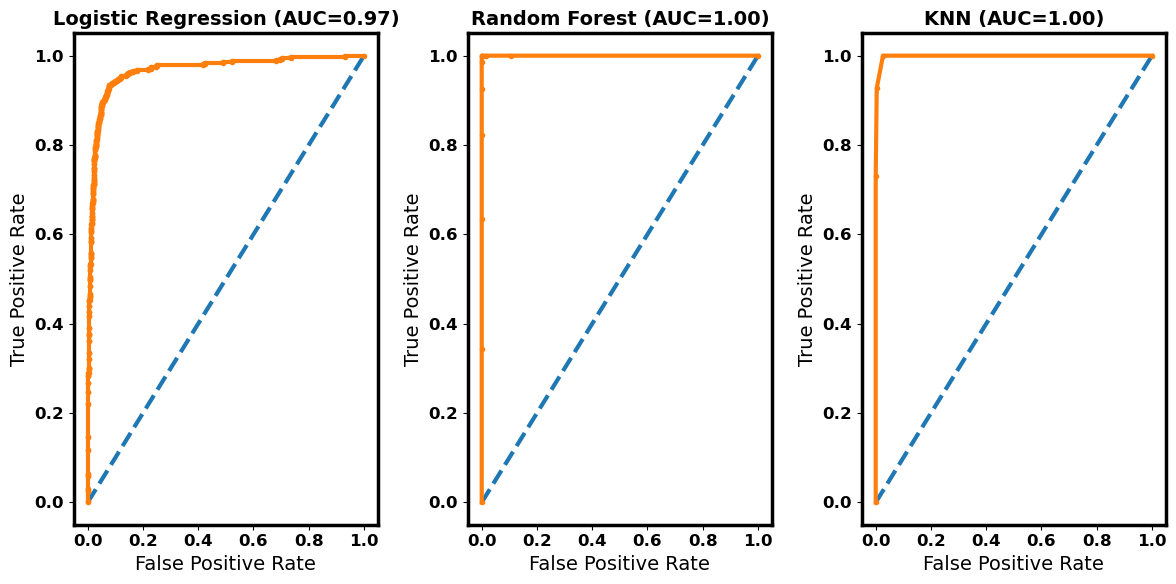

In [10]:
# ROC curves for binary classifier: Is Digit/Is not Digit
clh.AUC_plot(X_train=mnh.X_train, y_train=y_train_d, X_test=mnh.X_train, y_test=y_train_d)


The "ideal" curve would resemble an inverted "L"
- With a top, horizontal line near a TPR of $1$
- That rises vertically from a FPR of near $0$
 

That would imply that there is a choice of threshold with low FPR and high TPR.

**You** decide which threshold produces an acceptable trade-off

But you can also compare the curves across models
- A model whose curve is closer to the inverted "L" shape has a better trade-off
- We can measure this by the *Area Under the Curve* (AUC) of the model
    - Higher AUC gets us closer to the ideal
- The model whose curve has highest AUC might be the model of choice.

**Note on the mechanics of plotting the ROC/AUC**

To produce the ROC/AUC curve
- Fit a binary classifier
- For each possible value of the threshold
    - Predict using this threshold
    - Evaluate the TPR and FPR
    - This gives a single point on the curve

Fortunately: most ML toolkits will implement this process for you
- But the principle of "there is no magic" means that you should always understand what is happening

### $F_1$: Another way to combine Precision and Recall

There another metric call the $F_1$ which expresses the trade-off between Precision and Recall as a single number:

$$
\textrm{F}_1 = { { \textrm{TP} } \over { \textrm{TP} +  { { \textrm{FN} + \textrm{FP} }   \over 2 } }  }
$$

# Multinomial classification: Confusion matrix

So far we have been dealing with a classifier with only two classes.

So the simple grid

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

was sufficient.

The generalization of the grid to  multiple classes is called the *Confusion Matrix*

Here is the Confusion Matrix for a classifier on the task of predicting which of 10 digits
is represented by an image (MNIST digit recognition)

Normalized confusion matrix


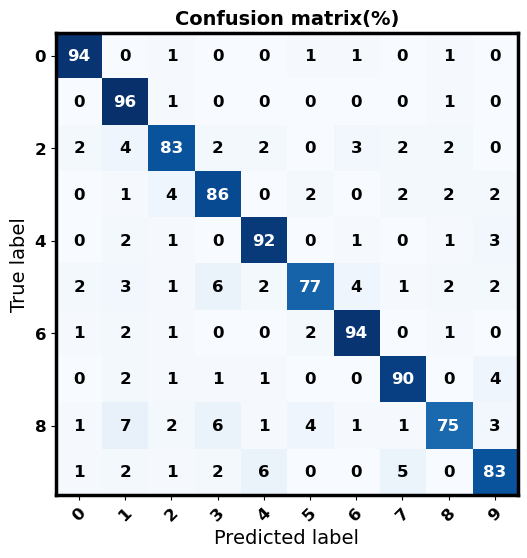

In [11]:
# Now predict the value of the digit on the second half:
fig, ax = plt.subplots(figsize=(12,6))
confusion_mat = mnh.create_confusion_matrix()

digits = range(0,10)
_= clh.plot_confusion_matrix(confusion_mat, digits, ax=ax, normalize=True)

The entry in the matrix for row $i$, column $j$
- **Percentage** of examples for true digit $i$ that were
predicted as digit $j$.

The diagonal of the Confusion Matrix is the Recall for each digit/

The non-diagonal elements of a row show how often a given digit was mistaken for another.

**Confusion warning**

Our Binary Confusion matrix has True label and Predicted label axes swapped
- Predicted label as row label
- our plot is consistent with 
`sklearn`'s `ConfusionMatrixDisplay`
- Row labels: the *true* class
- Column labels: the *predicted* class

The confusion matrix for MNIST digit recognition tells us that our classifier
- Does a great job (90+% correct) on images corresponding to digits 0,1,6
- Is struggling ($ < 80 \%$ correct) on images of the digits 5, 8
    - Mis-classifying them as "3" most often


Studying the Confusion Matrix in depth can help you
- Diagnose the weaknesses in your model
- And *perhaps take steps to compensate* for them (improve the model)
- By analyzing the examples belonging to the subset corresponding to non-diagonal entries

**This is the true power of Error Analysis !**
- Having a process and the tools to diagnose mis-prediction will make you more successful !
- That is why we emphasize the importance of the Error Analysis step of the Recipe

We will perform this analysis *in code*  for the MNIST digit classifier shortly.

<img src="images/Back_to_parent.jpg">

## Regression: beyond RMSE/$R^2$

What is the process of diagnosing errors for the Regression task ?

Answer: Examining the residuals.
- the difference $\y^\ip - \hat\y^\ip$

Recall our first attempt at Linear Regression
- where we systematically *under-predicted* (positive residuals) the Target
- for low and high values of the single feature $\x_1$

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
         
    
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split 

import linearReg_helper as lrh
%aimport linearReg_helper


In [13]:
lr_demo = lrh.LinReg()
(fig_scatter, fig_x1, fig_x1_x1sq) = lr_demo.createFigs(visible=False)

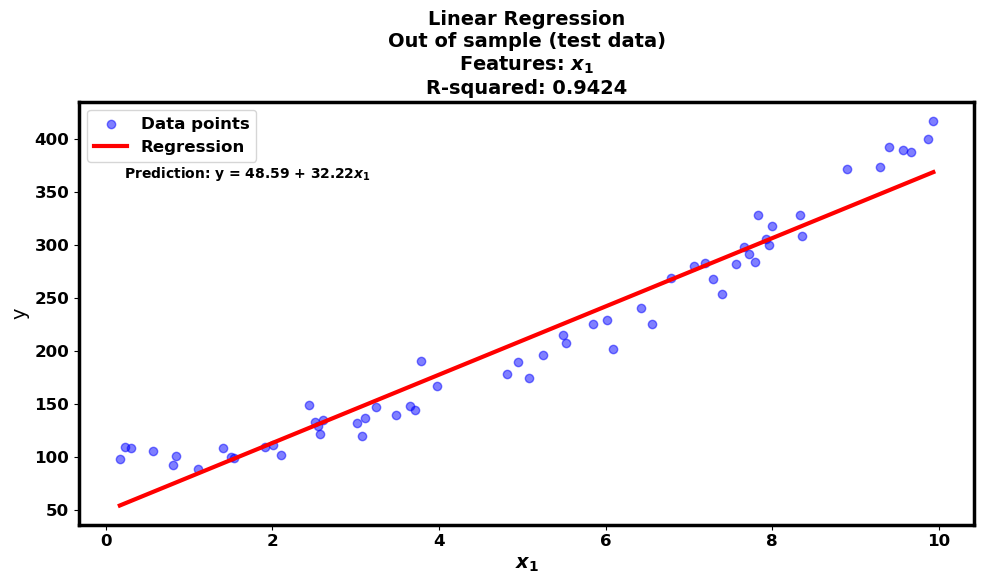

In [14]:
fig_x1

Our Error Analysis
- observing the systematic mispricing

led us to improve the model
- by adding a second feature $\x_1^2$

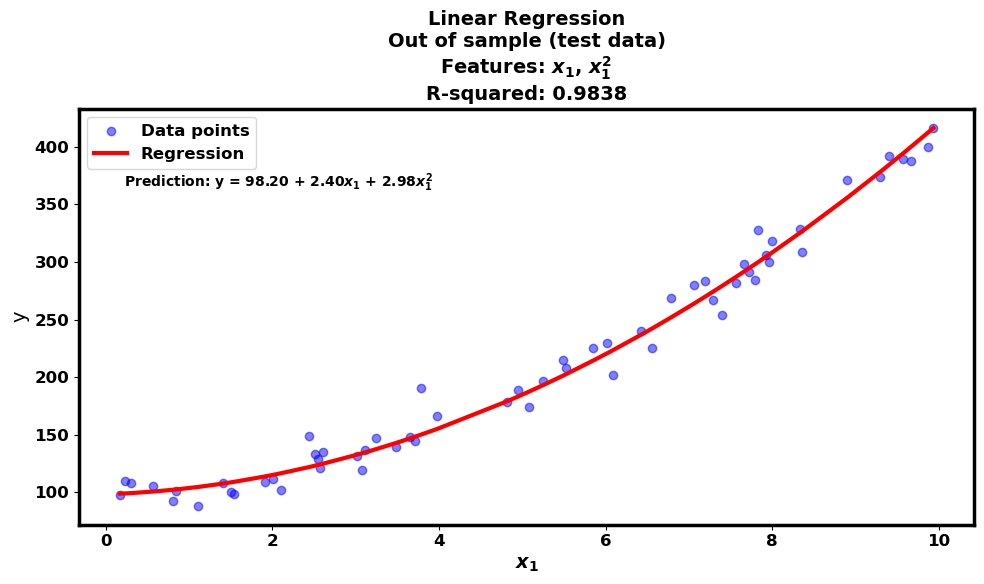

In [15]:
fig_x1_x1sq

In [16]:
print("Done")

Done
